# **Heart disease prediction**

La predicción de enfermedades cardíacas es un área crítica en la medicina moderna, ya que las enfermedades cardiovasculares son una de las principales causas de muerte a nivel mundial. Identificar de manera temprana a los individuos en riesgo permite intervenciones oportunas que pueden salvar vidas y mejorar la calidad de vida de los pacientes.

En este notebook, se aborda la predicción de enfermedades cardíacas utilizando técnicas de aprendizaje automático. Se utiliza un conjunto de datos que incluye diversas características clínicas y demográficas de los pacientes, tales como la edad, el sexo, el colesterol, el nivel de azúcar en sangre, entre otros. Estas características servirán como variables independientes en el modelo predictivo, mientras que la presencia o ausencia de enfermedad cardíaca será la variable dependiente que se intenta predecir.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df_heart = pd.read_csv("heart.csv")

# Introducción

## Visualización inicial

In [ ]:
print(f'Las columnas de los datos son: \n {df_heart.columns}')

Las columnas de los datos son: 
 Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')


In [ ]:
df_heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease: output class [1: heart disease, 0: Normal]

In [ ]:
#comprobamos el tamaño del dataset
df_heart.shape

(918, 12)

In [ ]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
df_heart.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [ ]:
df_heart.describe(include= "all")

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918,918,918.000000,918.000000,918.000000,918,918.000000,918,918.000000,918,918.000000
unique,NaN,2,4,NaN,NaN,NaN,3,NaN,2,NaN,3,NaN
top,NaN,M,ASY,NaN,NaN,NaN,Normal,NaN,N,NaN,Flat,NaN
freq,NaN,725,496,NaN,NaN,NaN,552,NaN,547,NaN,460,NaN
mean,53.510893,NaN,NaN,132.396514,198.799564,0.233115,NaN,136.809368,NaN,0.887364,NaN,0.553377
std,9.432617,NaN,NaN,18.514154,109.384145,0.423046,NaN,25.460334,NaN,1.066570,NaN,0.497414
min,28.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,60.000000,NaN,-2.600000,NaN,0.000000
25%,47.000000,NaN,NaN,120.000000,173.250000,0.000000,NaN,120.000000,NaN,0.000000,NaN,0.000000
50%,54.000000,NaN,NaN,130.000000,223.000000,0.000000,NaN,138.000000,NaN,0.600000,NaN,1.000000
75%,60.000000,NaN,NaN,140.000000,267.000000,0.000000,NaN,156.000000,NaN,1.500000,NaN,1.000000


In [ ]:
# Pasar variables categóricas a objecto (para la visualización)
df_heart["HeartDisease"] = df_heart["HeartDisease"].astype("object")
df_heart["FastingBS"] = df_heart["FastingBS"].astype("object")

## Visualización de variables numéricas (boxplot) y categóricas (barplot)

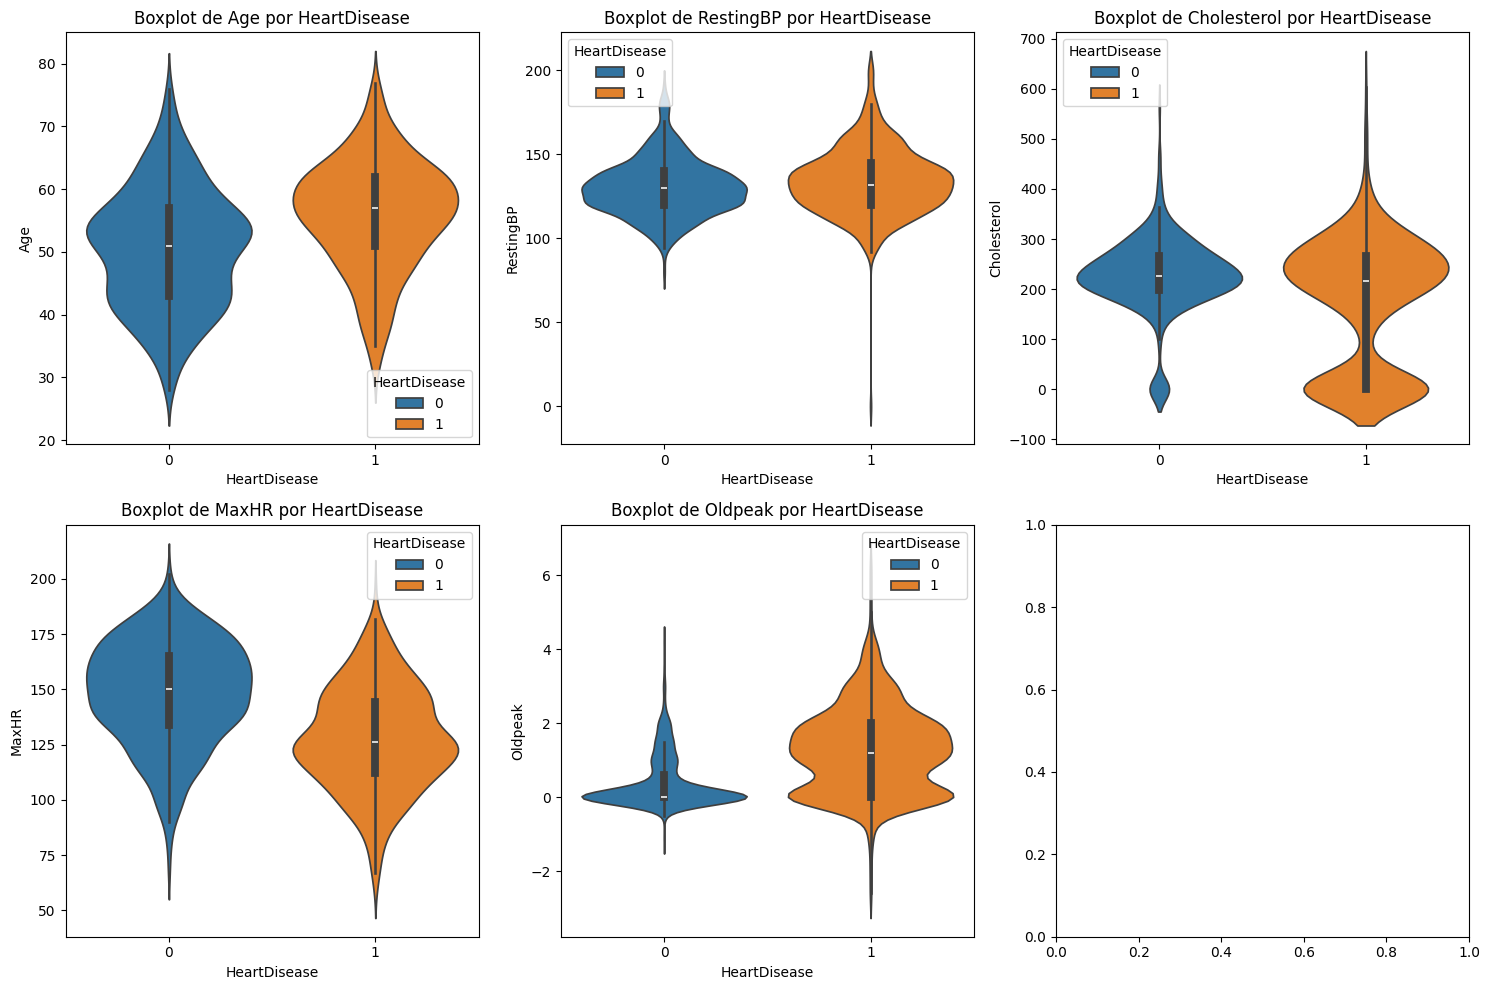

In [ ]:
# Paleta de colores preestablecida
sns.set_palette("tab10")

# Lista de variables para hacer boxplots
numeric_columns = df_heart.select_dtypes(include=['int64', 'float64'])

# Crear subplots para los boxplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Iterar sobre las variables y crear los boxplots
for i, variable in enumerate(numeric_columns.columns):
    row = i // 3
    col = i % 3
    sns.violinplot(x = "HeartDisease", y=variable, data=df_heart, ax=axes[row, col], hue = "HeartDisease")
    axes[row, col].set_title(f'Boxplot de {variable} por HeartDisease')

plt.tight_layout()
plt.show()

* Más común con la edad
* Bastante parecido en Resting BP. Hay algún valor erróneo quizás en 0 dado que no podemos tener 0 mm Hg de presión.
* El nivel saludable de colesterol suele ser de menor de 170 mg/dL. Existen valores anormales, ya que parece que haya muchos valores == 0. Deberían ser NaN values.
* MaxHR suele ser menor en personas con HeartDisease == 0, el rango de valores es normal.
* Old peak valores absolutos altos cuando HeartDisease == 0. Muchos valores en 0, podría ser normal dado que el rango normal está entre -0.5 y 0.5.

In [ ]:
df_heart[df_heart["RestingBP"]<50]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


Dado que solo es un valor vamos a imputarle la mediana.

In [ ]:
# Calcula la mediana de "RestingBP"
median_resting_bp = df_heart["RestingBP"].median()

# Imputa la mediana en las filas donde "RestingBP" es menor que 50
df_heart.loc[df_heart["RestingBP"] < 50, "RestingBP"] = median_resting_bp

In [ ]:
# Procedemos a mirar con detenimiento el colesterol
df_heart[df_heart["Cholesterol"]<100].sort_values(by = "Cholesterol")

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
378,70,M,ASY,140,0,1,Normal,157,Y,2.0,Flat,1
402,65,M,ASY,145,0,1,ST,67,N,0.7,Flat,1
403,52,M,ASY,135,0,1,Normal,128,Y,2.0,Flat,1
404,47,M,NAP,110,0,1,Normal,120,Y,0.0,Flat,1
405,35,M,ASY,120,0,1,Normal,130,Y,1.2,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
351,43,M,ASY,140,0,0,ST,140,Y,0.5,Up,1
352,56,M,ASY,120,0,0,ST,100,Y,-1.0,Down,1
353,58,M,ASY,130,0,0,ST,100,Y,1.0,Flat,1
345,69,M,ASY,135,0,0,Normal,130,N,0.0,Flat,1


El valor de cholesterol de 85 puede ser real aunque sea muy bajo pero tiene un pico de 0.0, y su restingBP es muy bajo. Podría ser atleta o alguien muy deportista.
Los otros valores no son correctos. Dado que hay 172 valores incorrectos vamos a observar como podemos imputar el valor. No podemos imputarlo según la mediana de la población que sí tiene HeartDisease dado que estaríamos alimentando al algoritmo con un sesgo imputado por nosotros.
Haremos un regresión lineal para imputar los valores de Cholesterol y posteriormente vamos a hacer nuestras predicciones.

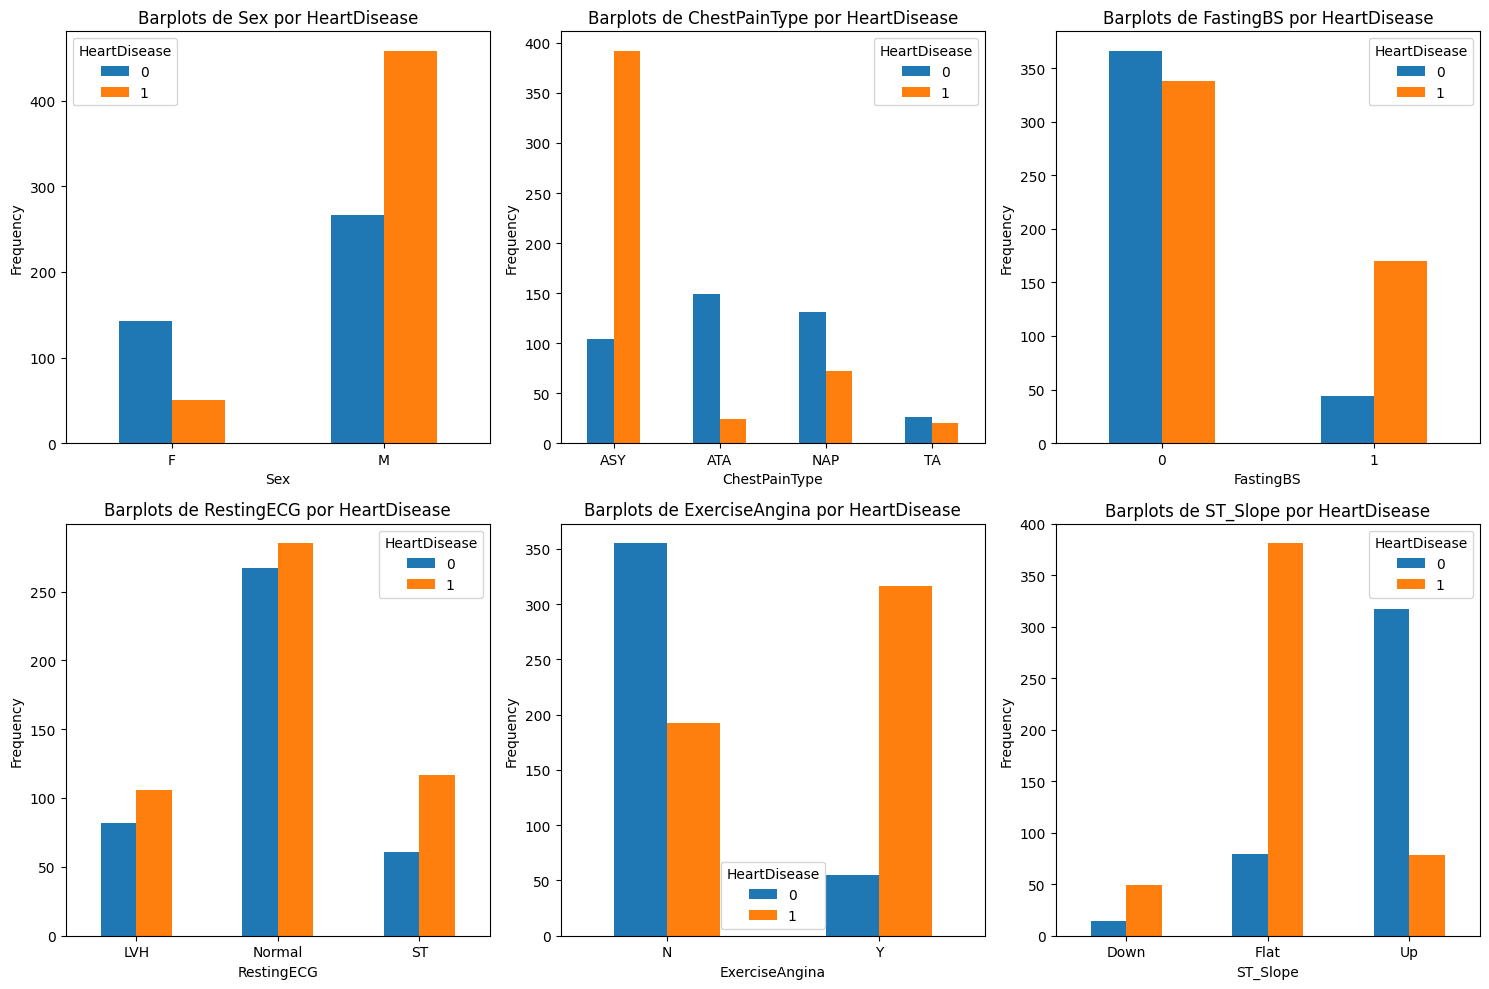

In [ ]:
# Lista de variables para hacer barplots
categoric_columns = df_heart.select_dtypes(include=['object'])
categoric_columns = categoric_columns.drop(columns=['HeartDisease'], errors='ignore')

# Crear subplots para los barplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Iterar sobre las variables y crear los barplots
for i, variable in enumerate(categoric_columns.columns):
    row = i // 3
    col = i % 3

    # Calcular la frecuencia de cada categoría para HeartDisease == 0 y HeartDisease == 1
    category_counts = df_heart.groupby([variable, "HeartDisease"]).size().unstack()

    # Crear el gráfico de barras con las frecuencias
    category_counts.plot(kind="bar", ax=axes[row, col])

    # Establecer títulos y etiquetas de los ejes
    axes[row, col].set_title(f'Barplots de {variable} por HeartDisease')
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel('Frequency')

    # Rotar las etiquetas del eje x horizontalmente
    axes[row, col].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

* Más común en hombres, con el tipo de dolor ASY y con Fasting Blood sugar == 0 (sabiendo que [1: if FastingBS > 120 mg/dl, 0: otherwise])
* Proporción parecida entre los distintos tipos de ECG en reposo, un poco más si es ST (con abnormalidad en el tramo ST)
* Más común cuando exercise-induced angina
* Muy común cuando el tramo ST no tiene pendiente.

In [ ]:
# Hacer one-hot
# Creamos una instancia del transformador OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' para evitar la multicolinealidad

# Ajustamos y transformamos las variables categóricas
encoded_features = encoder.fit_transform(categoric_columns)

# Obtén los nombres de las nuevas columnas después de la codificación
encoded_columns = encoder.get_feature_names_out(categoric_columns.columns)

# Creamos un nuevo DataFrame con las variables codificadas
df_encoded = pd.DataFrame(encoded_features, columns=encoded_columns)

# Features
X = pd.concat([numeric_columns, df_encoded], axis=1)

# Label
y = df_heart["HeartDisease"]

In [ ]:
X

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,172,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180,156,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,98,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,138,214,108,1.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,54,150,195,122,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,132,1.2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
914,68,144,193,141,3.4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
915,57,130,131,115,1.2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
916,57,130,236,174,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Imputación de los valores de colesterol

In [ ]:
# Elimina las filas con colesterol 0 para usar solo datos válidos
X_filtered = X[X['Cholesterol'] != 0]

# Define las características (variables independientes) y la variable objetivo
Xx = X_filtered.drop("Cholesterol", axis = 1)  # Variables independientes
yy = X_filtered['Cholesterol']  # Variable objetivo

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(Xx, yy, test_size=0.2, random_state=42)

# Crea un modelo de regresión lineal
model = LinearRegression()

# Entrena el modelo
model.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Calcula el error cuadrático medio (MSE) para evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 3823.0727576419586


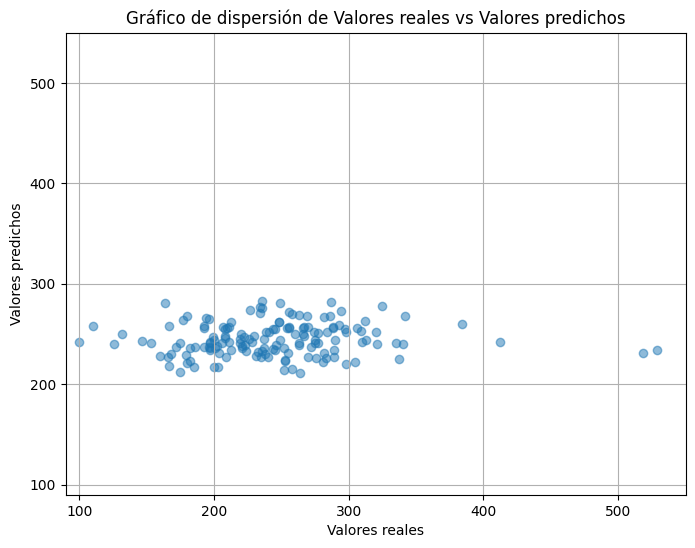

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Gráfico de dispersión de Valores reales vs Valores predichos')
plt.grid(True)
plt.xlim(90, 550)
plt.ylim(90, 550)
plt.show()

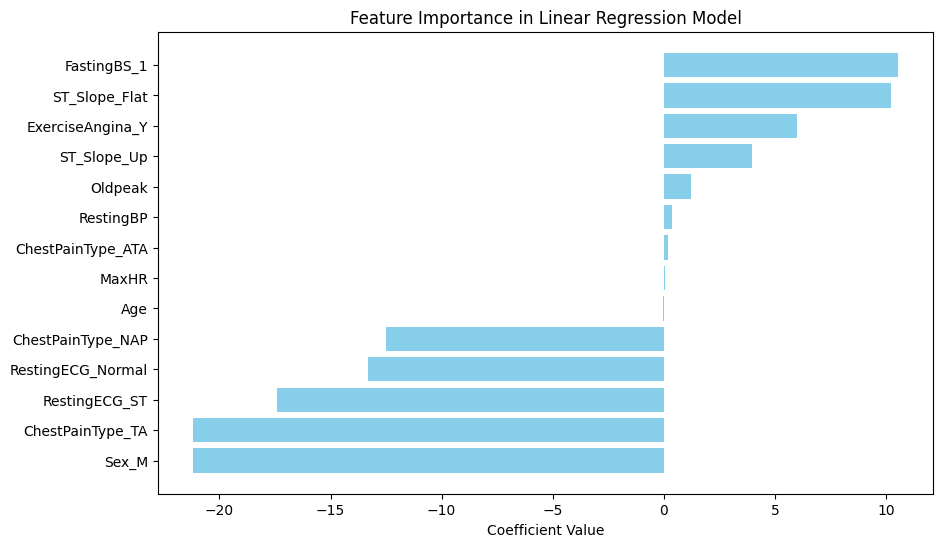

In [ ]:
# Obtener los coeficientes de regresión del modelo entrenado
coefficients = model.coef_

# Crear un DataFrame para visualizar los coeficientes junto con el nombre de las características
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression Model')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la característica más importante arriba
plt.show()

In [ ]:
# Crear un modelo de regresión polinómica de grado 3
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Entrenar el modelo de regresión polinómica
model.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio (MSE) para evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 7718.864506936669


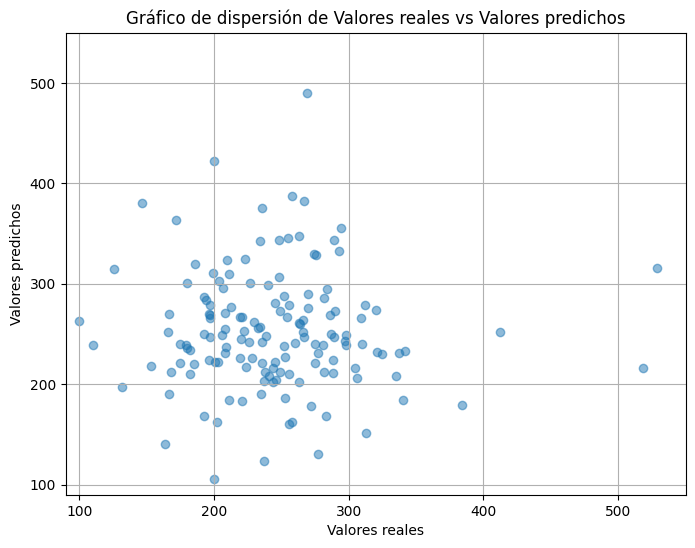

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Gráfico de dispersión de Valores reales vs Valores predichos')
plt.grid(True)
plt.xlim(90, 550)
plt.ylim(90, 550)
plt.show()

Dado que este modelo es ligeramente mejor y da valores más posibles. Vamos a generar otra vez el modelo con todos los datos del train (todos los datos que tenemos con el valor del cholesterol) y vamos a imputar los valores.

In [ ]:
# 1. Filtrar el DataFrame para obtener solo las filas donde el colesterol es diferente de 0

X_filtered = X[X['Cholesterol'] != 0]

# Definir las características (variables independientes) y la variable objetivo
X_train = X_filtered.drop("Cholesterol", axis=1)  # Variables independientes
y_train = X_filtered['Cholesterol']  # Variable objetivo

# 2. Utilizar validación cruzada para entrenar el modelo y evaluar su desempeño

# Crear un modelo de regresión polinómica de grado 3
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Realizar predicciones con validación cruzada
y_pred_cross_val = cross_val_predict(model, X_train, y_train, cv=5)  # 5-fold cross-validation

# 3. Realizar predicciones en las filas con colesterol igual a 0 y asignar los valores predichos

X_impute = X[X['Cholesterol'] == 0].drop("Cholesterol", axis=1)  # Filtrar filas con colesterol igual a 0

# Entrenar el modelo con todos los datos sin validación cruzada
model.fit(X_train, y_train)

# Realizar predicciones en las filas con colesterol igual a 0
y_pred_impute = model.predict(X_impute)

# Asignar los valores predichos a las filas correspondientes en el DataFrame original
X.loc[X['Cholesterol'] == 0, 'Cholesterol'] = y_pred_impute

## Visualización final

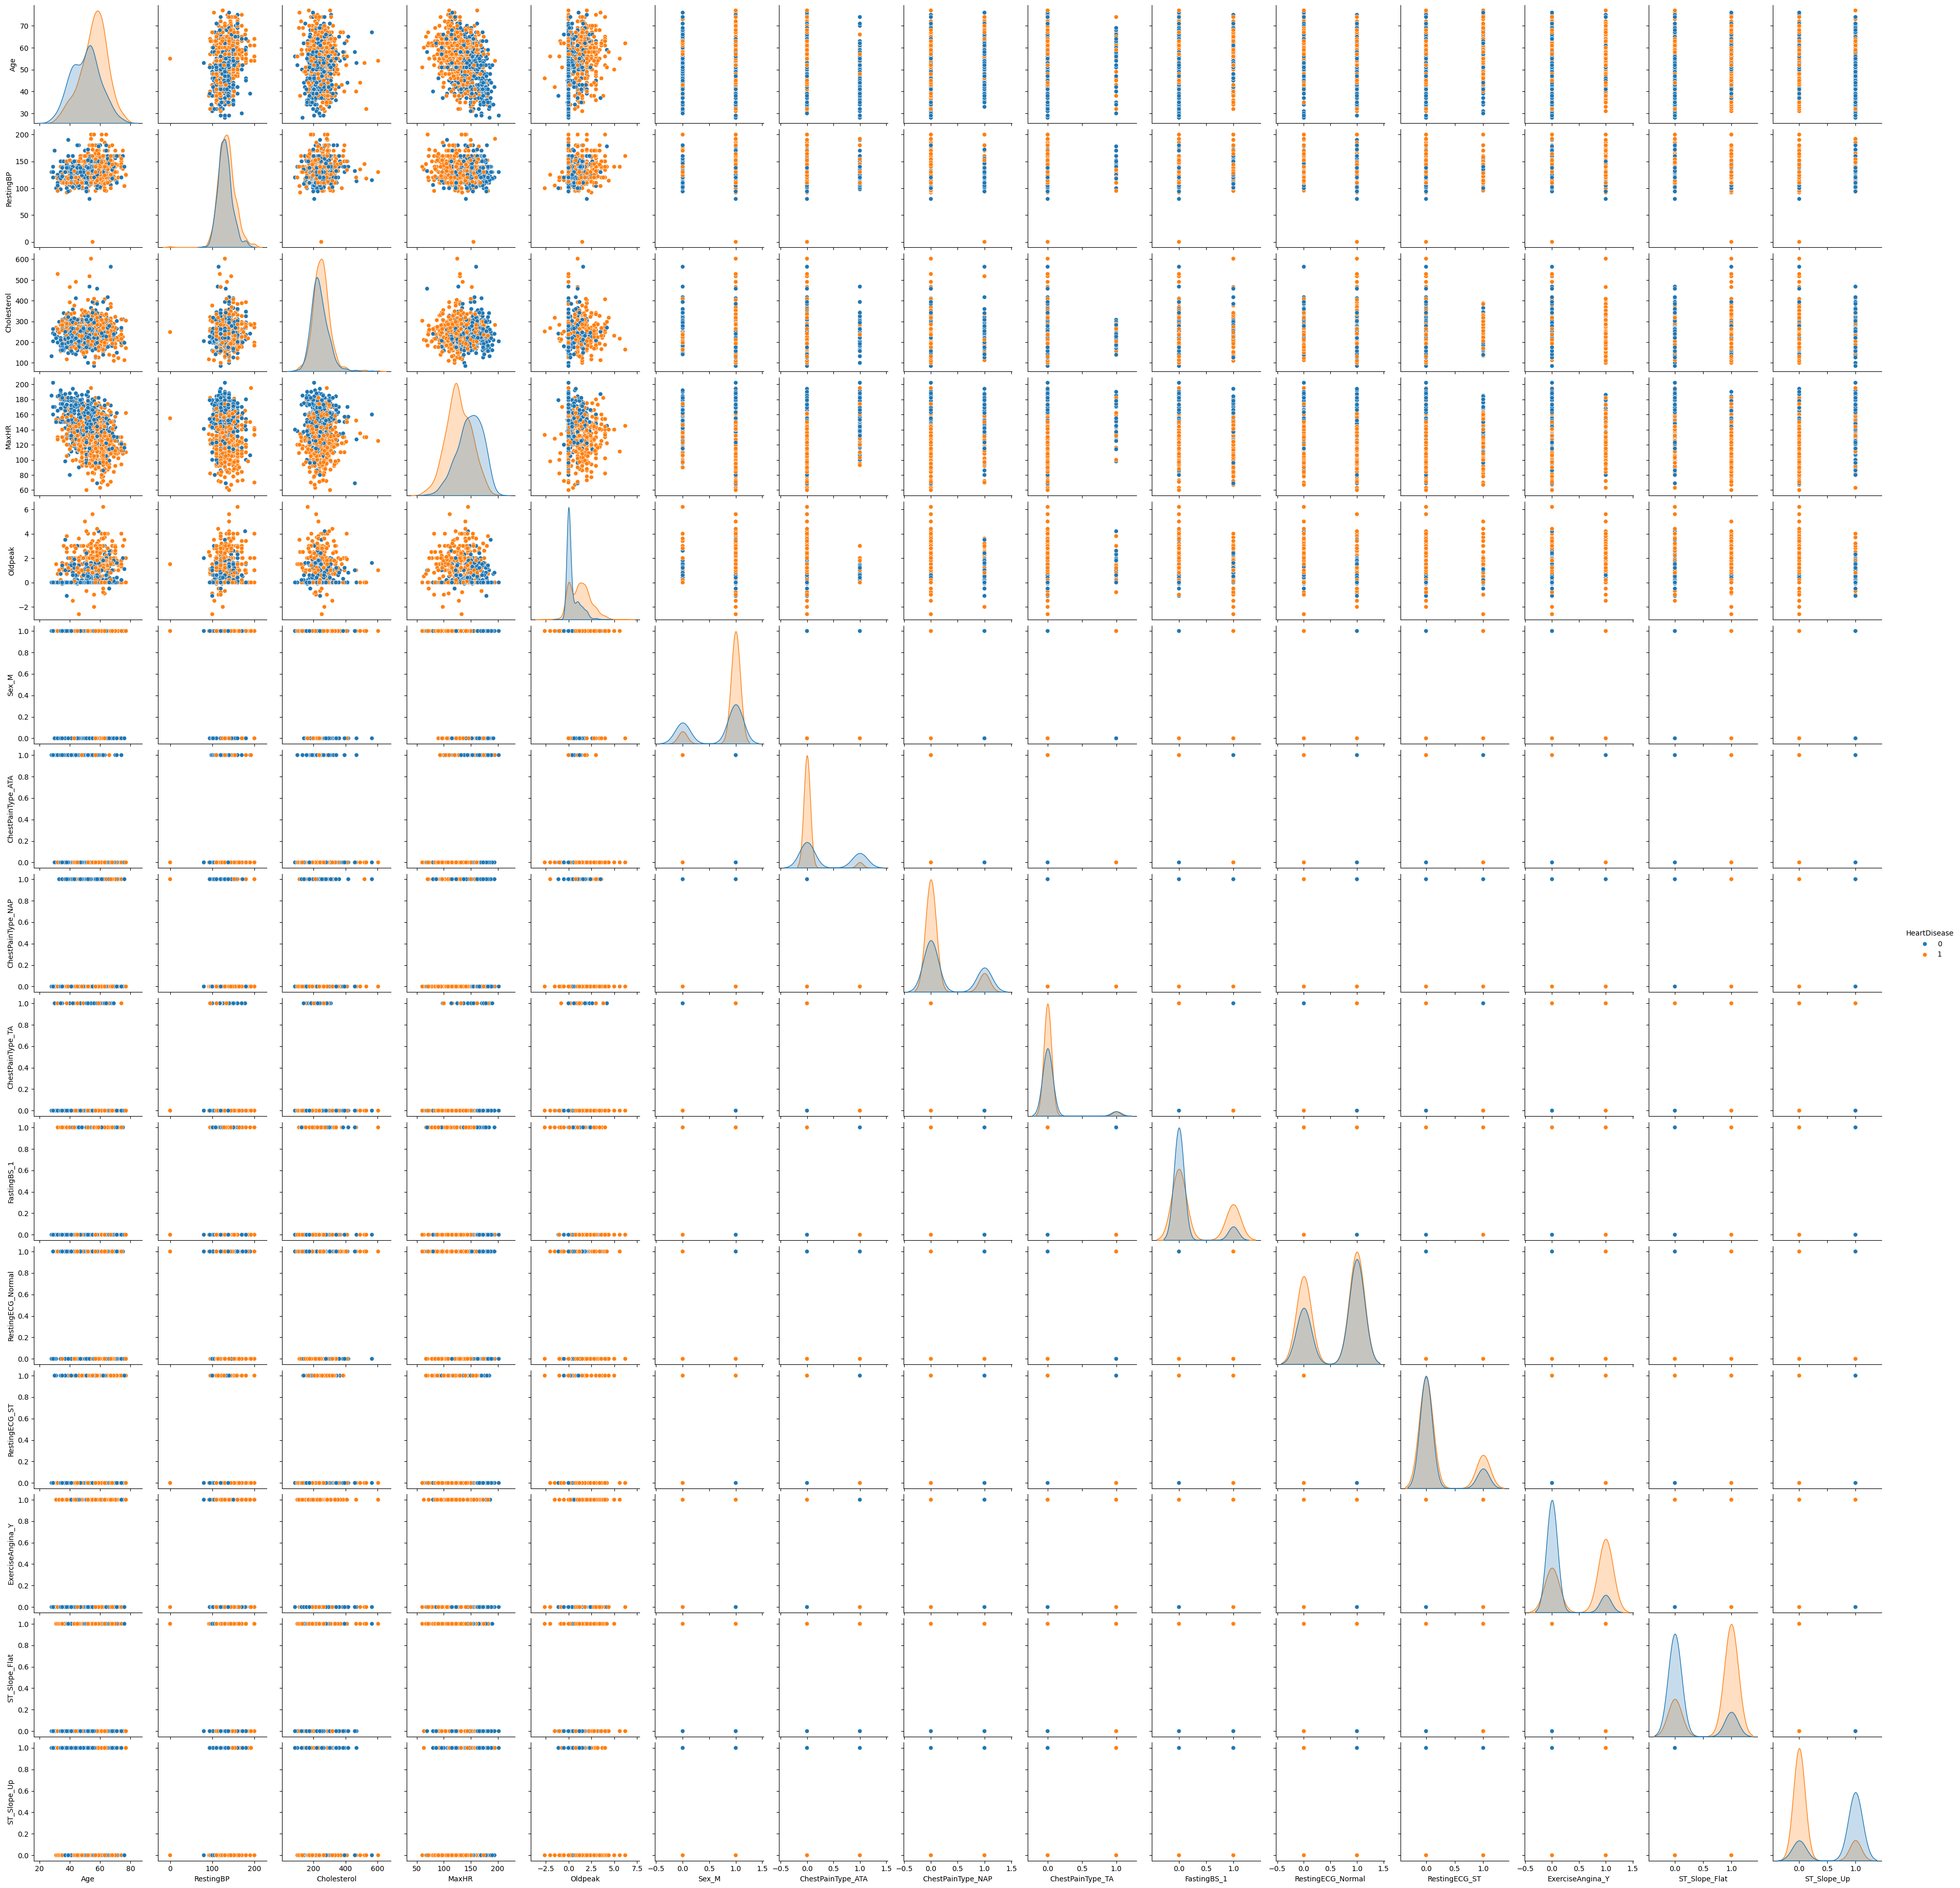

In [ ]:
Xy = pd.concat([X, y], axis=1)
sns.pairplot(Xy, hue = "HeartDisease")
plt.show()

## Correlacions i VIF

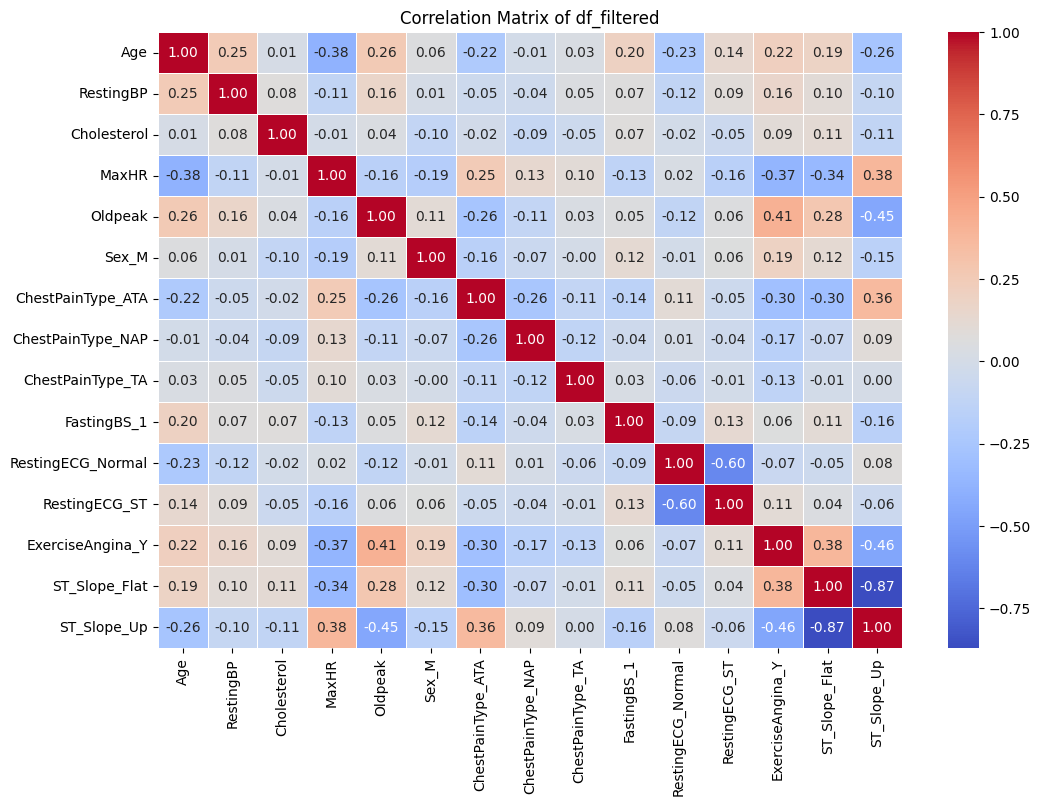

In [ ]:
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of df_filtered')
plt.show()

In [ ]:
# Crear un DataFrame para almacenar los resultados del VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Visualizar el DataFrame con los resultados del VIF
print(vif_data)

              Feature        VIF
0                 Age  32.112025
1           RestingBP  49.775938
2         Cholesterol  19.883637
3               MaxHR  28.262432
4             Oldpeak   2.575794
5               Sex_M   4.901746
6   ChestPainType_ATA   1.839516
7   ChestPainType_NAP   1.636751
8    ChestPainType_TA   1.182994
9         FastingBS_1   1.435837
10  RestingECG_Normal   3.831651
11      RestingECG_ST   1.972290
12   ExerciseAngina_Y   2.642205
13      ST_Slope_Flat   8.317779
14        ST_Slope_Up   9.081980


In [ ]:
X = X.drop("RestingBP", axis = 1)
# Crear un DataFrame para almacenar los resultados del VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Visualizar el DataFrame con los resultados del VIF
print(vif_data)

              Feature        VIF
0                 Age  23.483535
1         Cholesterol  18.992781
2               MaxHR  25.599334
3             Oldpeak   2.546567
4               Sex_M   4.863467
5   ChestPainType_ATA   1.831869
6   ChestPainType_NAP   1.635813
7    ChestPainType_TA   1.179242
8         FastingBS_1   1.435667
9   RestingECG_Normal   3.785690
10      RestingECG_ST   1.942566
11   ExerciseAngina_Y   2.600197
12      ST_Slope_Flat   7.964109
13        ST_Slope_Up   8.724616


In [ ]:
X = X.drop("MaxHR", axis = 1)
# Crear un DataFrame para almacenar los resultados del VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Visualizar el DataFrame con los resultados del VIF
print(vif_data)

              Feature        VIF
0                 Age  22.192945
1         Cholesterol  15.948098
2             Oldpeak   2.444334
3               Sex_M   4.793479
4   ChestPainType_ATA   1.743876
5   ChestPainType_NAP   1.555816
6    ChestPainType_TA   1.150360
7         FastingBS_1   1.434612
8   RestingECG_Normal   3.760529
9       RestingECG_ST   1.942479
10   ExerciseAngina_Y   2.572965
11      ST_Slope_Flat   7.363178
12        ST_Slope_Up   7.233726


In [ ]:
X = X.drop("Age", axis = 1)
# Crear un DataFrame para almacenar los resultados del VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Visualizar el DataFrame con los resultados del VIF
print(vif_data)

              Feature        VIF
0         Cholesterol  12.186161
1             Oldpeak   2.222948
2               Sex_M   4.555226
3   ChestPainType_ATA   1.739022
4   ChestPainType_NAP   1.516601
5    ChestPainType_TA   1.137664
6         FastingBS_1   1.395529
7   RestingECG_Normal   3.745507
8       RestingECG_ST   1.902109
9    ExerciseAngina_Y   2.538124
10      ST_Slope_Flat   6.383199
11        ST_Slope_Up   6.168575


In [ ]:
X = X.drop("Cholesterol", axis = 1)
# Crear un DataFrame para almacenar los resultados del VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Visualizar el DataFrame con los resultados del VIF
print(vif_data)

              Feature       VIF
0             Oldpeak  2.066757
1               Sex_M  4.469748
2   ChestPainType_ATA  1.709406
3   ChestPainType_NAP  1.505130
4    ChestPainType_TA  1.134548
5         FastingBS_1  1.353879
6   RestingECG_Normal  3.630417
7       RestingECG_ST  1.887140
8    ExerciseAngina_Y  2.472341
9       ST_Slope_Flat  4.122639
10        ST_Slope_Up  3.874459


In [ ]:
# Los valores y tenían que ser numéricas para funcione GridSearch
y = pd.Series(y.astype("int"))

In [ ]:
X.isnull().sum()
X.shape

(918, 11)

# Clustering

En este apartado aplicaremos otra de las técnicas de aprendizaje no supervisado que tenemos a mano: el clustering. El objetivo será ver cuál es la clasificación que nos hace el algoritmo de todos los pacientes en función de sus diferentes características. Para ello, vamos a tratar con el dataset X, que parte de una modificación del df_heart al cual le hemos hecho el one-hot enconding y la asignación de los valores de colesterol correctos mediante regresión.

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Oldpeak            918 non-null    float64
 1   Sex_M              918 non-null    float64
 2   ChestPainType_ATA  918 non-null    float64
 3   ChestPainType_NAP  918 non-null    float64
 4   ChestPainType_TA   918 non-null    float64
 5   FastingBS_1        918 non-null    float64
 6   RestingECG_Normal  918 non-null    float64
 7   RestingECG_ST      918 non-null    float64
 8   ExerciseAngina_Y   918 non-null    float64
 9   ST_Slope_Flat      918 non-null    float64
 10  ST_Slope_Up        918 non-null    float64
dtypes: float64(11)
memory usage: 79.0 KB


Para poder llevar a cabo la clasificación de los pacientes, usaremos el algoritmo de K-Means. Este algoritmo, mediante la entrada del número de clústeres que deseamos obtener, nos permite obtener la mejor clasificación de los datos según el número que le hayamos dado.

Seguiremos los siguientes pasos:

1. Probaremos K-Means con un numero aleatorio y veremos gráficamente como se agrupa según dos variables dadas.

2. Aplicaremos el método Elbow para identificar el número óptimo de clústeres y reharemos el algoritmo de KMeans según este número. También reharemos las visualizaciones.

3. Aplicaremos la técnica de reducción de dimensionalidad PCA y definiremos el número de componentes principales de manera gráfica.

4. Terminaremos rehaciendo la vista gráfica y dando una explicación sobre los clústeres identificados.

Cabe mencionar que la elección de las variables significativas para poder ver los clústeres gráficamente la hemos hecho viendo cuáles tenían una mayor correlación entre ellas (respecto Age).

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


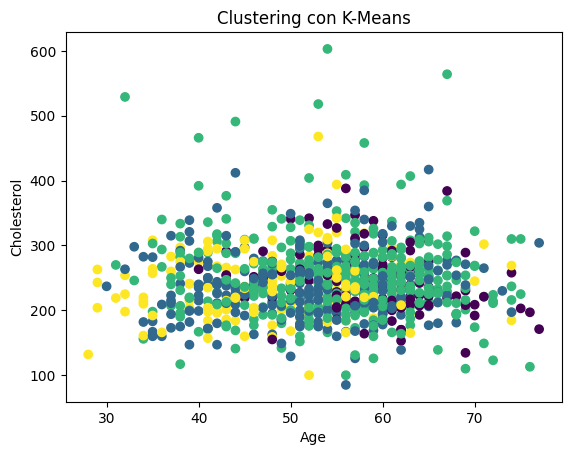

In [ ]:
# Empezamos estandarizando los datos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

# Aplicamos K-Means con 4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)
Xy['Cluster'] = kmeans.labels_

# Eligimos la edad y el colesterol para ver las agrupaciones de manera gráfica
plt.scatter(Xy['Age'], Xy['Cholesterol'], c=Xy['Cluster'], cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.title('Clustering con K-Means')
plt.show()

Comprobamos que, aun habiendo agrupado los datos según 4 clústeres diferentes, no podemos explicar según edad o colesterol como se han agrupado estos pacientes. Procederemos ahora a ver cuál sería el número ideal de clústeres.

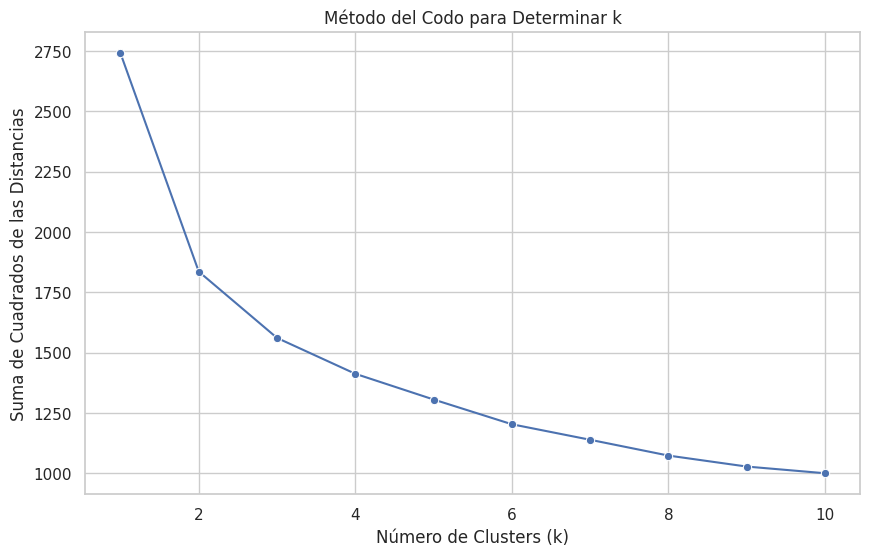

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Calculamos la suma de los cuadrados de las distancias para diferentes valores de k
sum_of_squared_distances = []
K_range = range(1, 11)  # Probamos con k desde 1 hasta 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    sum_of_squared_distances.append(kmeans.inertia_)


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=K_range, y=sum_of_squared_distances, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Suma de Cuadrados de las Distancias')
plt.title('Método del Codo para Determinar k')
plt.show()

Segñun el método del codo, el punto donde termina de disminuir la pendiente drásticamente es en los 3 clusteres.

Ahora recalcularemos el algoritmo segun k = 3

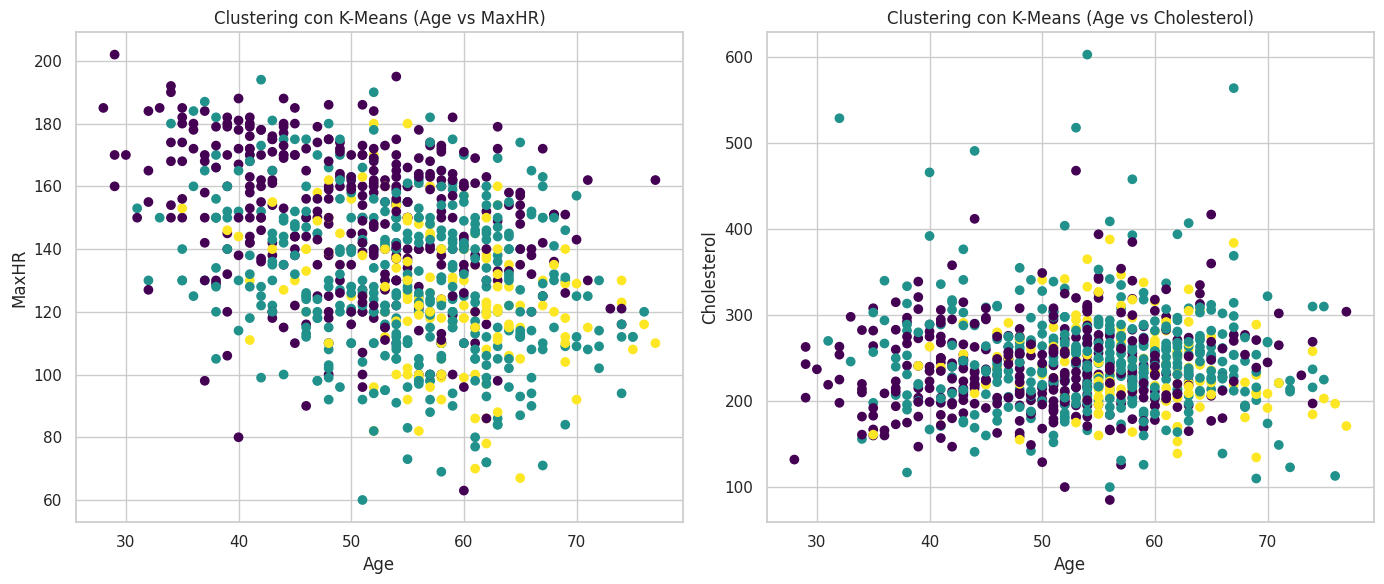

In [ ]:
# Aplicamos K-Means con k =3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_features)
Xy['Cluster'] = kmeans.labels_

# Creamos una figura con dos subplots
plt.figure(figsize=(14, 6))

# Primer gráfico: Age vs MaxHR
plt.subplot(1, 2, 1)
plt.scatter(Xy['Age'], Xy['MaxHR'], c=Xy['Cluster'], cmap='viridis')
plt.xlabel('Age')
plt.ylabel('MaxHR')
plt.title('Clustering con K-Means (Age vs MaxHR)')

# Segundo gráfico: Age vs Cholesterol
plt.subplot(1, 2, 2)
plt.scatter(Xy['Age'], Xy['Cholesterol'], c=Xy['Cluster'], cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.title('Clustering con K-Means (Age vs Cholesterol)')


plt.tight_layout()

plt.show()

En esta ocasión, observamos como los 3 clusteres se empiezan a diferenciar en ambas vistas. Sin embargo, muchos puntos parecen juntarse en el centro y no terminan de diferenciarse entre los clústeres. Esto podría ser un signo de que se podría aplicar PCA para reducir la dimensionalidad de nuestros datos.

Aplicando el PCA, lo que se busca es maximizar la varianza de los datos proyectados en los componentes principales.

Para aplicar el PCA es necesario indicar el número de componentes principales a los que queremos reduicir nuestros datos. Una manera de determinar este número podría ser calculando la varianza explicada acumulativa por cada componente principal y, después, trazando un gráfico para visualizarla.

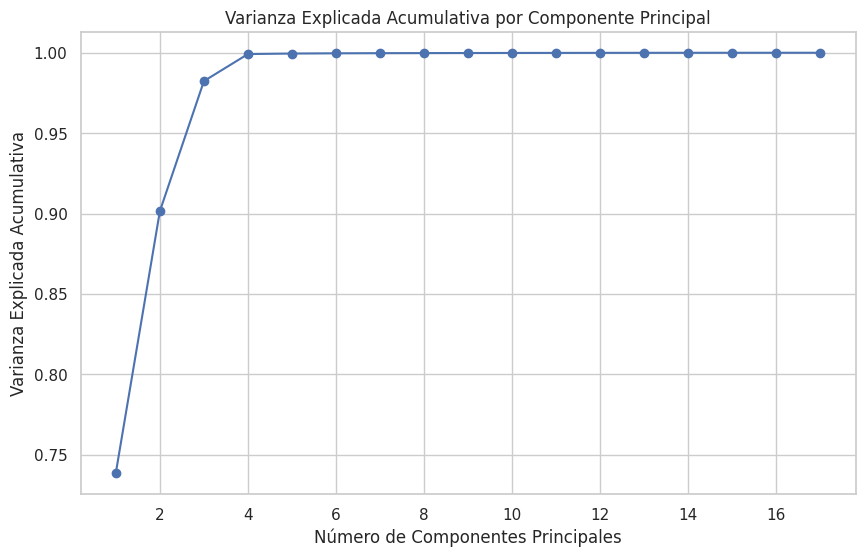

In [ ]:
# Aplicamos PCA a nuestros datos
pca = PCA()
X_pca = pca.fit_transform(Xy)

# Calculamos la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Calculamos la varianza explicada acumulativa
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulativa')
plt.title('Varianza Explicada Acumulativa por Componente Principal')
plt.grid(True)
plt.show()

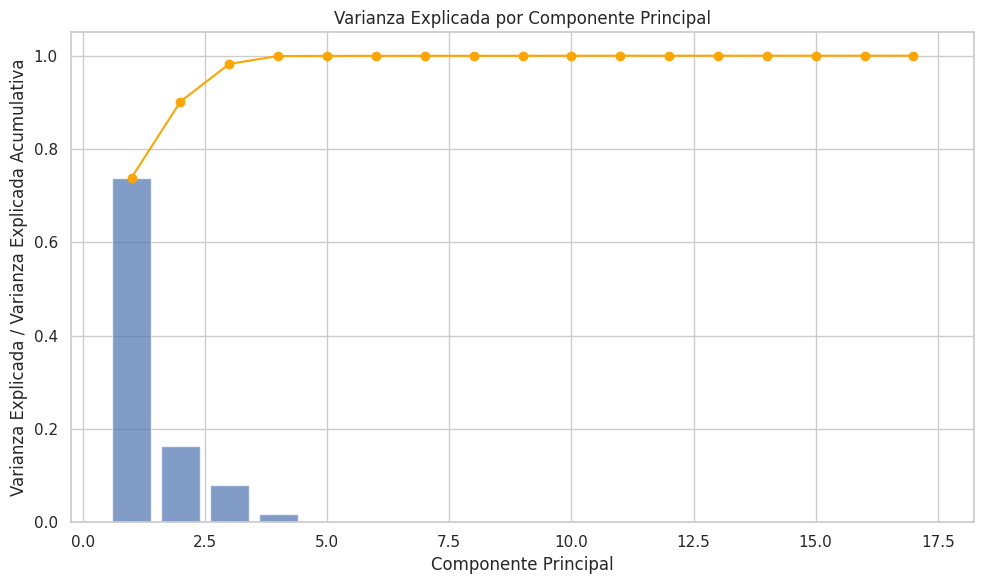

In [ ]:
# Misma vista añadiendo el gráfico de barras
pca = PCA()
X_pca = pca.fit_transform(Xy)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, color='orange', marker='o', linestyle='-')

# Configuración de etiquetas y título
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada / Varianza Explicada Acumulativa')
plt.title('Varianza Explicada por Componente Principal')
plt.grid(True)

# Mostramos la gráfica
plt.tight_layout()
plt.show()

En este caso, para seleccionar el número de componentes principales que capturan la mayoría de la varianza, nos basaremos en el porcentaje de varianza explicada acumulativa del 90-95%, lo cual corresponde a 3 componentes principales.

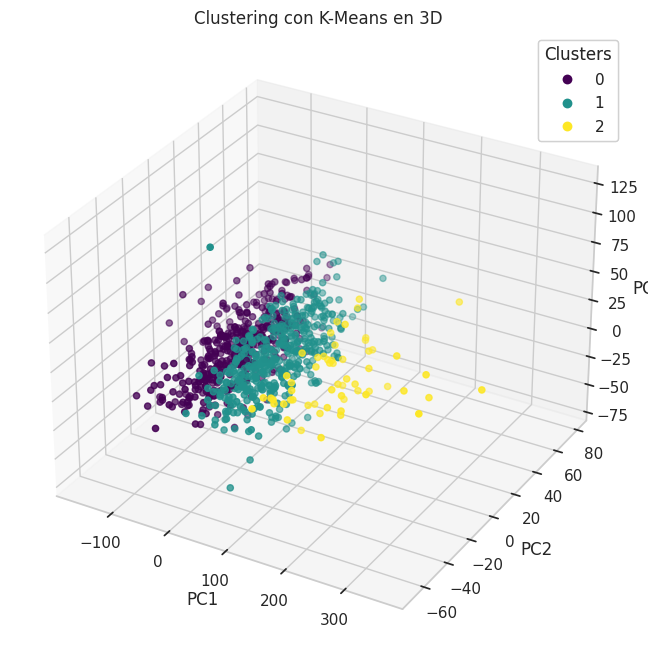

In [ ]:
# Reducimos la dimensionalidad con PCA a 3 componentes principales
pca = PCA(n_components=3)
X_pca = pca.fit_transform(Xy)

# Ejecutamos K-Means otra vez en los datos transformados por PCA
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)
labels = kmeans.labels_

# Visualizamos los resultados del clustering en un gráfico tridimensional
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D con los datos de PCA coloreados por los clusters
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')

# Etiquetas de los ejes
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC2')


# Título del gráfico
plt.title('Clustering con K-Means en 3D')

# Leyenda
legend = ax.legend(*scatter.legend_elements(), title='Clusters')
ax.add_artist(legend)


plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Obtenemos los loadings de los componentes principales y lo ponemos el un df
loadings = pca.components_
loadings_df = pd.DataFrame(loadings, columns=Xy.columns)
print("Loadings de las características en cada componente principal:")
loadings_df

Loadings de las características en cada componente principal:


,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease,Cluster
0,0.001704,0.028620,0.999579,-0.003719,0.000727,-0.000770,-0.000144,-0.000681,-0.000180,0.000566,-0.000147,-0.000376,0.000859,0.001001,-0.001020,0.000963,0.000621
1,0.165659,0.175368,-0.008954,-0.970198,0.007771,0.002927,-0.003927,-0.002118,-0.000725,0.002357,-0.000965,0.002608,0.007259,0.006712,-0.007465,0.007862,0.010954
2,-0.103442,-0.975059,0.027380,-0.194251,-0.007605,0.000766,-0.000275,-0.000054,-0.000975,-0.000886,0.003214,-0.001263,-0.001525,-0.000173,-0.000109,-0.000122,-0.000990


Como hemos explicado, con este codigo, se nos ha generado un gráfico tridimensional donde cada punto está representado por sus características originales según cada componente principal, y coloreado según el cluster al que pertenece. Podemos ver como los 3 clusteres ahora están claramente diferenciados. Además, hemos calculado los loadings (o pesos) de cada una de los componentes principale y hemos identificado que las features Cholesterol, Age y restingBP son los que tienen más pesos en el PC1, PC2 y PC3 respectivamente.

In [ ]:
#vamos a verlo en un gráfico 3D que permita movimiento
#en eje X pondremos el feature de mas peso de PC1 (colesterol)
#en Y pondremos el feature de más peso de PC2 (Age)
#en Z pondremos el feature de más peso del PC3 (RestingBP)

fig=px.scatter_3d(X, x=Xy['Age'],y=Xy['Cholesterol'], z=Xy['RestingBP'],color=labels)
fig.update_layout(scene=dict(xaxis_title='Age', yaxis_title='Cholesterol', zaxis_title='RestingBP'))

fig.show()

Mediantes esta vista gráfica en 3D, podemos extraer más visualmente las conclusiones de los 3 clústeres:

- Cluster 0 (en azul oscuro): grupo de todas las edades, con un nivel de colesterol medio y con diferentes ritmos cardíacos en reposo

- Cluster 1 (en rojo): grupo de todas las edades, con un nivel de colesterol muy alto y con diferentes ritmos cardíacos en reposo

- Cluster 2 (en amarillo): grupo de todas las edades, con un nivel de colesterol normal (por debajo de 200) y con diferentes ritmos cardíacos en reposo.


Por lo tanto, de las 3 características, vemos como parece que el nivel de colesterol en sangre sería el factor más representativo a la hora de diferenciar entre clúster

# Classification

## Logistic Regression

In [ ]:
Xy.drop(columns = "Cluster", inplace = True)
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Definir el modelo de regresión logística
model = LogisticRegression()

# Definir los parámetros que deseas ajustar, incluyendo fit_intercept y multi_class
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverso de la fuerza de regularización
    'penalty': ['l2'],                # Tipo de regularización
    'fit_intercept': [True, False],         # Indica si se debe calcular el intercepto para el modelo
    'multi_class': ['auto', 'ovr', 'multinomial']  # Método para manejar múltiples clases
}

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', verbose=1)

# Entrenar el modelo con la búsqueda en cuadrícula
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor puntaje
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores Hiperparámetros encontrados:")
print(best_params)
print("Mejor Recall de Validación Cruzada:", best_score)

# Obtener el mejor modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba
predictions = best_model.predict(X_test)

# Evaluar el modelo en el conjunto de prueba
accuracy = accuracy_score(y_test, predictions)
print("\nExactitud del modelo en el conjunto de prueba:", accuracy)

print("\nInforme de Clasificación:")
print(classification_report(y_test, predictions))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores Hiperparámetros encontrados:
{'C': 0.001, 'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2'}
Mejor Recall de Validación Cruzada: 0.9701234567901234

Exactitud del modelo en el conjunto de prueba: 0.842391304347826

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80        77
           1       0.83      0.92      0.87       107

    accuracy                           0.84       184
   macro avg       0.85      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



La exactitud del modelo es bastante sólida, del 84.24%. Casi el 85% de las predicciones hechas por el modelo coinciden con las clasificaciones reales en el conjunto de prueba. Si bien la exactitud es una métrica importante, es crucial tener en cuenta que puede no ser suficiente por sí sola, especialmente en conjuntos de datos desequilibrados como este.

El informe de clasificación proporciona métricas adicionales como la precisión (la proporción de casos positivos clasificados correctamente), el recall (la proporción de casos positivos que fueron identificados correctamente) y la F1-score (una media armónica de precisión y recall) para cada clase. En resumen, el modelo parece tener un buen rendimiento general, con precisiones y recalls razonables para ambas clases. Sin embargo, sería importante profundizar más en el contexto específico de la aplicación y considerar otras métricas y técnicas de evaluación, especialmente si hay consideraciones especiales sobre los falsos positivos o falsos negativos.

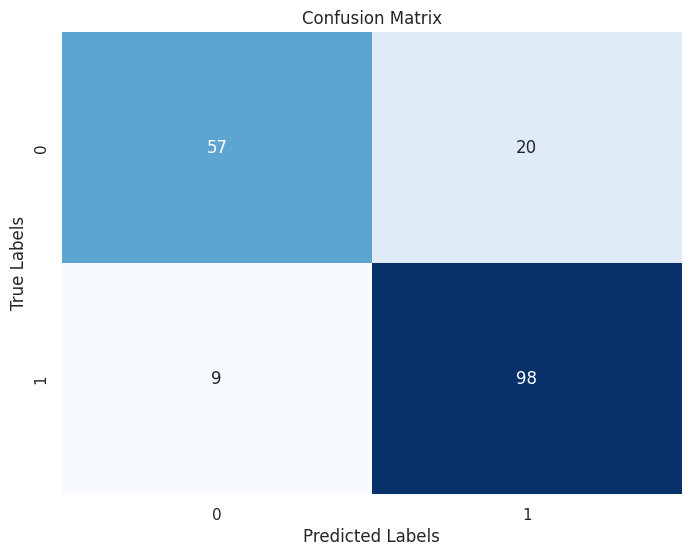

In [ ]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, predictions)

# Crear un mapa de calor utilizando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

 La matriz de confusión muestra los resultados de la clasificación en un formato más detallado. Aquí se puede ver que el modelo clasificó correctamente a 66 instancias de la clase 0 (sin enfermedad) y 89 instancias de la clase 1 (con enfermedad). No obstante, también ha cometido errores al clasificar 11 instancias de la clase 0 como clase 1, y 18 instancias de la clase 1 como clase 0.

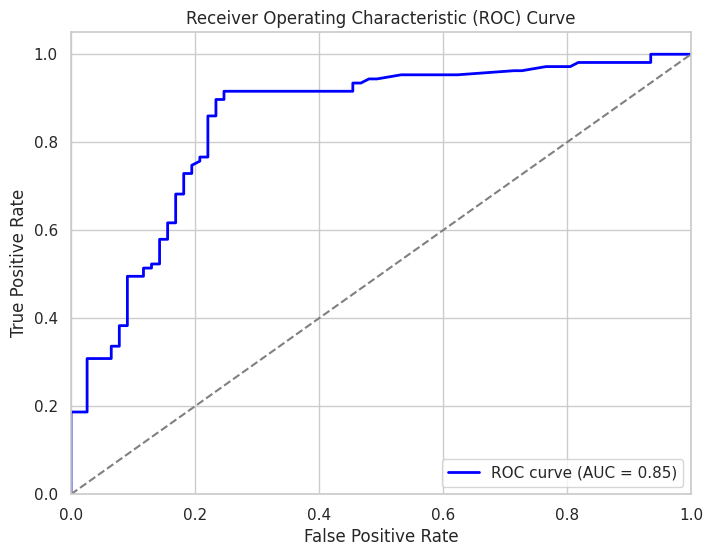

In [ ]:
# Calcular las probabilidades de clase de las muestras de prueba
y_probs = best_model.predict_proba(X_test)

# Usar solo las probabilidades de la clase positiva (clase 1)
y_probs = y_probs[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_probs)

# Trazar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

La curva ROC es otra herramienta útil para evaluar el rendimiento de nuestro modelo de clasificación binaria. La AUC es 0.92, lo cual es bastante alto. Esto indica que el modelo tiene una excelente capacidad para distinguir entre las instancias positivas y negativas. En otras palabras, si seleccionamos una pareja aleatoria de instancias, una positiva y una negativa, hay un 92% de probabilidad de que el modelo clasifique correctamente la instancia positiva con una puntuación de probabilidad más alta que la instancia negativa.

## Random Forest

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 5, 10, 20],    # Profundidad máxima de cada árbol
    'min_samples_split': [5, 10, 20],     # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 5],        # Número mínimo de muestras requeridas en cada hoja de un nodo
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}]  # Peso más alto para la clase 1
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, error_score='raise')
grid_search.fit(X, y)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Best Parameters: {'class_weight': {0: 1, 1: 4}, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 100}
Best Accuracy: 0.9506891865657154



Informe de Clasificación utilizando los mejores parámetros:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85        77
           1       0.86      0.96      0.91       107

    accuracy                           0.89       184
   macro avg       0.90      0.87      0.88       184
weighted avg       0.89      0.89      0.88       184



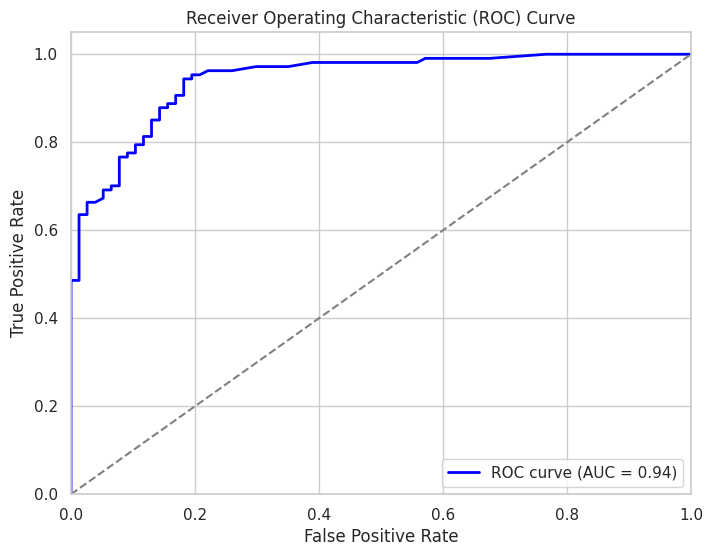

In [ ]:
# Después de grid_search.fit(X, y), obtener el mejor estimador
best_rf_classifier = grid_search.best_estimator_

# Utilizar el mejor estimador para predecir las etiquetas en el conjunto de prueba
predictions_best = best_rf_classifier.predict(X_test)

# Generar el informe de clasificación utilizando las etiquetas verdaderas (y_test) y las predicciones del mejor estimador
print("\nInforme de Clasificación utilizando los mejores parámetros:")
print(classification_report(y_test, predictions_best))

# Calcular las probabilidades de clase de las muestras de prueba
y_probs = best_rf_classifier.predict_proba(X_test)

# Usar solo las probabilidades de la clase positiva (clase 1)
y_probs = y_probs[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_probs)

# Trazar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

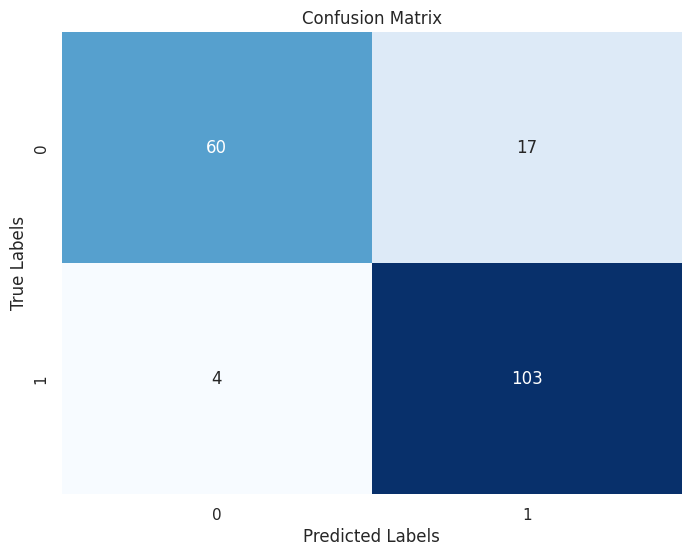

In [ ]:
predictions = best_rf_classifier.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, predictions)

# Crear un mapa de calor utilizando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()